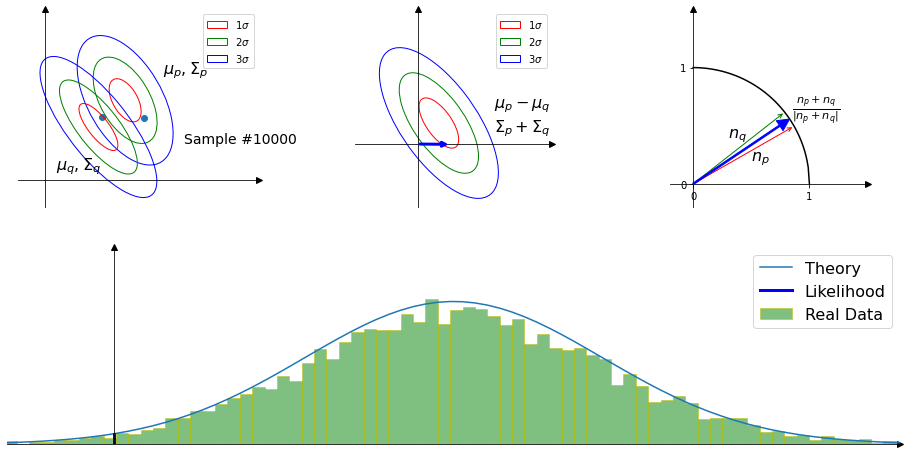

In [120]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython import display
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from math import floor, sqrt
import scipy.stats

def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

def bookstyle(ax):
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

def ell(xy, cov, ax, n_std, facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(xy[0], xy[1])
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def draw_ell(ax, u, c, leg=True):
    ell(u, c, ax, 1, edgecolor='r', label='$1\sigma$')
    ell(u, c, ax, 2, edgecolor='g', label='$2\sigma$')
    ell(u, c, ax, 3, edgecolor='b', label='$3\sigma$')
    if (leg):
        ax.legend()

def nm(cov):
    ed = np.linalg.eig(cov)
    if (ed[0][0] < ed[0][1]):
        return ed[1][:, 0]
    else:
        return ed[1][:, 1]

class UpdateData:
    def __init__(self, fig, up, cp, uq, cq):
        self.up, self.cp, self.uq, self.cq = up, cp, uq, cq
        self.pn, self.qn = -nm(cp), -nm(cq)
        self.upq, self.cpq = up - uq, cp + cq
        self.npq = (self.pn + self.qn) / np.linalg.norm(self.pn + self.qn)

        # Theory
        self.mean = self.upq.dot(self.npq)
        self.stdev = sqrt(self.npq.dot(self.cpq.dot(self.npq)))

        self.ax_pt = fig.add_subplot(231)
        self.ax_pq = fig.add_subplot(232)
        self.ax_npq = fig.add_subplot(233)
        self.ax_e = fig.add_subplot(212)
        for ax in [self.ax_pt, self.ax_pq, self.ax_npq, self.ax_e]:
            bookstyle(ax)

        self.plot1()
        self.plot2()
        self.plot3()
        self.plot4()
        self.ps = np.random.multivariate_normal(up, cp, size=10000)
        self.qs = np.random.multivariate_normal(uq, cq, size=10000)
        
    def plot1(self):
        draw_ell(self.ax_pt, self.up, self.cp)
        draw_ell(self.ax_pt, self.uq, self.cq, False)
        self.ax_pt.annotate('$\mu_p, \Sigma_p$', xy=[2.2, 2], size=16)
        self.ax_pt.annotate('$\mu_q, \Sigma_q$', xy=[0.2, 0.2], size=16)
        self.ax_pt.set_xlim(-0.5, 4)
        self.ax_pt.set_ylim(-0.5, 3.2)
        self.art_pt = self.ax_pt.scatter([], [])
        self.art_n = self.ax_pt.annotate('Sample #0', xy=[2.6, 0.7], size=14)

    def plot2(self):
        draw_ell(self.ax_pq, self.upq, self.cpq)
        self.ax_pq.set_xlim(-1.5, 3.2)
        self.ax_pq.set_ylim(-1.5, 3.2)
        self.ax_pq.annotate('$\mu_p - \mu_q$\n$\Sigma_p + \Sigma_q$', [1.8, 0.3], size=16)
        self.art_pq = self.ax_pq.annotate('', xy=[0, 0], xytext=[0, 0], arrowprops=dict(arrowstyle='<-', facecolor='b', edgecolor='b', lw=3))

    def plot3(self):
        self.ax_npq.plot(np.linspace(0, 1, 100), np.sqrt(1 - np.linspace(0, 1, 100) ** 2), 'k')
        self.ax_npq.annotate('', xy=[0, 0], xytext=self.pn, arrowprops=dict(edgecolor='r', arrowstyle='<-'))
        self.ax_npq.annotate('', xy=[0, 0], xytext=self.qn, arrowprops=dict(edgecolor='g', arrowstyle='<-'))
        self.ax_npq.annotate('', xytext=[0, 0], xy=self.npq, arrowprops=dict(facecolor='b', edgecolor='b', width=1.5))
        self.ax_npq.annotate('$n_p$', [0.5, 0.2], size=16)
        self.ax_npq.annotate('$n_q$', [0.3, 0.4], size=16)
        self.ax_npq.annotate(r'$\frac{n_p+n_q}{\|n_p+n_q\|}$', [0.85, 0.6], size=16)
        self.ax_npq.set_xlim(-0.2, 1.5)
        self.ax_npq.set_ylim(-0.2, 1.5)
        self.ax_npq.set_xticks([0, 1])
        self.ax_npq.set_yticks([0, 1])
        
    def plot4(self):
        self.x = np.linspace(-0.5, 2, 100)
        y = [275 * scipy.stats.norm(self.mean, self.stdev).pdf(i) for i in self.x]
        self.ax_e.plot(self.x, y, label='Theory')
        self.ax_e.set_xlim(self.mean-3*self.stdev, self.mean+3*self.stdev)
        self.ax_e.set_ylim(-0.1, 500)
        self.ax_e.set_aspect('auto')
        _, _, self.art_e = self.ax_e.hist([], self.x, lw=1, ec='y', fc='g', alpha=0.5, label='Real Data')
        self.ax_e.plot([0, 0], [0, 275 * scipy.stats.norm(self.mean, self.stdev).pdf(0)], 'b', lw=3, label='Likelihood')
        self.ax_e.legend(fontsize=16)

    def __call__(self, i):
        p, q = self.ps[i * 200 - 1, :], self.qs[i * 200 - 1, :]
        pq = p - q

        self.art_n.set_text('Sample #{}'.format(i * 200))
        self.art_pt.set_offsets(np.stack((p, q)))
        self.art_pq.set_position(pq)

        sndt = []
        for i in range(i * 200):
            sndt.append((self.ps[i, :] - self.qs[i, :]).dot(self.npq))
        n, _ = np.histogram(sndt, self.x)
        for count, rect in zip(n, self.art_e.patches):
            rect.set_height(count)
        return self.art_pt, self.art_pq

up = np.array([1.5, 1.5])
cp = np.array([[0.08956964, -0.0624375 ], [-0.0624375 , 0.16318393]])
uq = np.array([1, 1])
cq = np.array([[0.13287857, -0.12345357], [-0.12345357, 0.19375536]])

fig = plt.figure(figsize=(16, 8))
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ud = UpdateData(fig, up, cp, uq, cq)
# fig.tight_layout()
# Animation
ani = FuncAnimation(fig, ud, frames=range(51), blit=True, interval=250, repeat_delay=1500)
# js = HTML(ani.to_jshtml())
# display.display(js)
# plt.close()

# Save File
ani.save('testing.gif', writer='imagemagick')

(-1.5, 3.2)

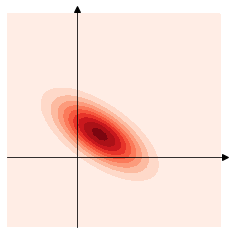

In [113]:
fig, ax = plt.subplots()
bookstyle(ax)
x = np.arange(-1.5, 3.2, 0.1)
y = x.reshape(-1, 1)
xx, yy = np.meshgrid(x, y)
zz = np.zeros((len(x), len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        zz[i, j] = scipy.stats.multivariate_normal(ud.upq, ud.cpq).pdf([x[i], y[j]])
cs = plt.contourf(xx, yy, zz, levels=10, cmap=plt.cm.Reds)
ax.set_xlim(-1.5, 3.2)
ax.set_ylim(-1.5, 3.2)
# cont = ax.contour(xx, yy, zz[i], levels=15, cmap=plt.cm.jet)
# h

In [65]:
# make it simple
class NormalAnimation:
    def __init__(self, fig, mean, stdev, sz):
        self.ax = fig.add_subplot(111)
        bookstyle(self.ax)
        self.ax.set_xlim(-2, 4)
        self.ax.set_ylim(0, 1000)
        self.ax.set_aspect('auto')
        self.data = np.random.normal(mean, stdev, sz)
        self.x = np.linspace(-2, 4, 100)
        n, _ = np.histogram(self.data, self.x)
        _, _, self.art = self.ax.hist([], self.x, lw=1, ec='y', fc='g', alpha=0.5)
        res = [1250 * scipy.stats.norm(mean, stdev).pdf(i) for i in self.x]
        self.ax.plot(self.x, res, '-')

    def __call__(self, i):
        n, _ = np.histogram(self.data[:i*200], self.x)
        for count, rect in zip(n, self.art.patches):
            rect.set_height(count)
        return self.art.patches

fig = plt.figure(figsize=(12, 4))
# fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
na = NormalAnimation(fig, 1, 1, 10000)
ani = FuncAnimation(fig, na, frames=range(50), blit=True)
js = HTML(ani.to_jshtml())
display.display(js)
plt.close()

(array([   9.,   57.,  321., 1141., 2460., 2896., 2014.,  880.,  204.,
          18.]),
 array([-3.07020462, -2.30848285, -1.54676108, -0.78503932, -0.02331755,
         0.73840421,  1.50012598,  2.26184775,  3.02356951,  3.78529128,
         4.54701304]),
 <BarContainer object of 10 artists>)

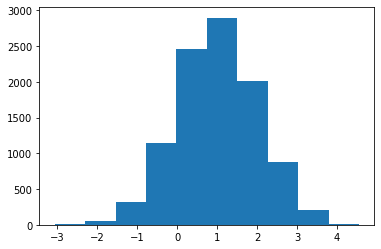

In [51]:
plt.hist(na.data)

In [119]:
p, q = ud.ps[i, :], ud.qs[i, :]
pq, e = p - q, np.linalg.norm(p - q)
print(pq.dot(ud.npq))

0.7163706234893172
